# Detecting Heartbeat Illnesses with Fourier Transform Features

*Lucas Wilson*, May 11, 2019

# Introduction


I am analyzing heartbeat data for anomolies. Electric pulses are measured for patients that are healthy 
controls and patients that are sick with Myocardial infarction. I wanted to explore two important 
concepts realted to signal analysis:
Wavelet Transforms and Fourier Transforms. Originally, I was going to forecast the time series with 
an ESN, but the results weren't strong enough, so instead, I decided to explore discrete wavelet 
transforms (DWT) and fast forier transofrms (FFT). 

Wavelet transforms look at details around local points as opposed to the entire signal. It's the "position" aspect of a signal. Fourier transforms are a decomposition of a signal into frequencies. This measures a larger portion of the signal and represents the "velocity" of a signal. The metaphor with the Uncertainty principle isn't exact, but gives a good general idea of what each represents \[[src](http://archive.schools.cimpa.info/archivesecoles/20110804111512/aline_slides.pdf)\]. Fourier transforms have also
been explained as the time series equivalent of PCA \[[src](https://www.quora.com/Is-there-something-like-principal-component-analysis-for-time-series)\].

I use major packages like `np.fft.rfft` (for FFT), `pywt` (for DWT), `wfdb` (wave format database for data parsing), and the `NeuralNetworkClassifier` (for classification) given from class. I wrote all python files except for `mlutilities.py` and `neuralnetworks.py`. `esn.py` was largely written for a different project, but it was adapted to be able to handle multiple TS samples in order to pass it multiple heartrate samples instead of just one. However, the performance wasn't strong enough to use, so I don't encorporate it. 

# Imports

In [233]:
import matplotlib.pyplot as plt
from data_reader import *
from random import shuffle
import numpy as np
from esn import EchoStateNetwork
from itertools import product
import pywt
from copy import deepcopy
import scipy.signal
import sklearn.metrics

from neuralnetworks import NeuralNetworkClassifier # CLASS CODE

%matplotlib inline
alpha_c = "\u03b1"
np.set_printoptions(precision=2)

# Getting the Data

The data comes from a website: 
https://physionet.org/physiobank/database/ptbdb/

The data set is a wave file database for many people and one
or more samples per person. The data is read with a package
called `wfdb`. I've written wrappers to download, load 
the data, and reformat it, so that's obscured from the report.

In [2]:
# Get the data
records = get_records()
orig_data = [get_data(record) for record in records]

First, we unpack the data. Then, we remove samples with no health status. First, we unpack the data. Then, we remove samples with no health status. We split the data into controls and sick patients.

In [222]:
# remove data missing labels
data = [record for record in orig_data if record['labels']['status'] != "n/a"]
print(f"Number of records {len(data)}")
healthy_data = [record for record in data if record['labels']['status'] == 'Healthy control']
shuffle(healthy_data)
print("Example shape of data: {}".format(healthy_data[0]['data'].shape))
print(f"Number of healthy controls: {len(healthy_data)}")
unhealthy_data = [record for record in data if record['labels']['status'] == 'Myocardial infarction']
shuffle(unhealthy_data)
print(f"Number of myocardial infarction: {len(unhealthy_data)}")

Number of records 522
Example shape of data: (120012, 15)
Number of healthy controls: 80
Number of myocardial infarction: 368


### Healthy Plot

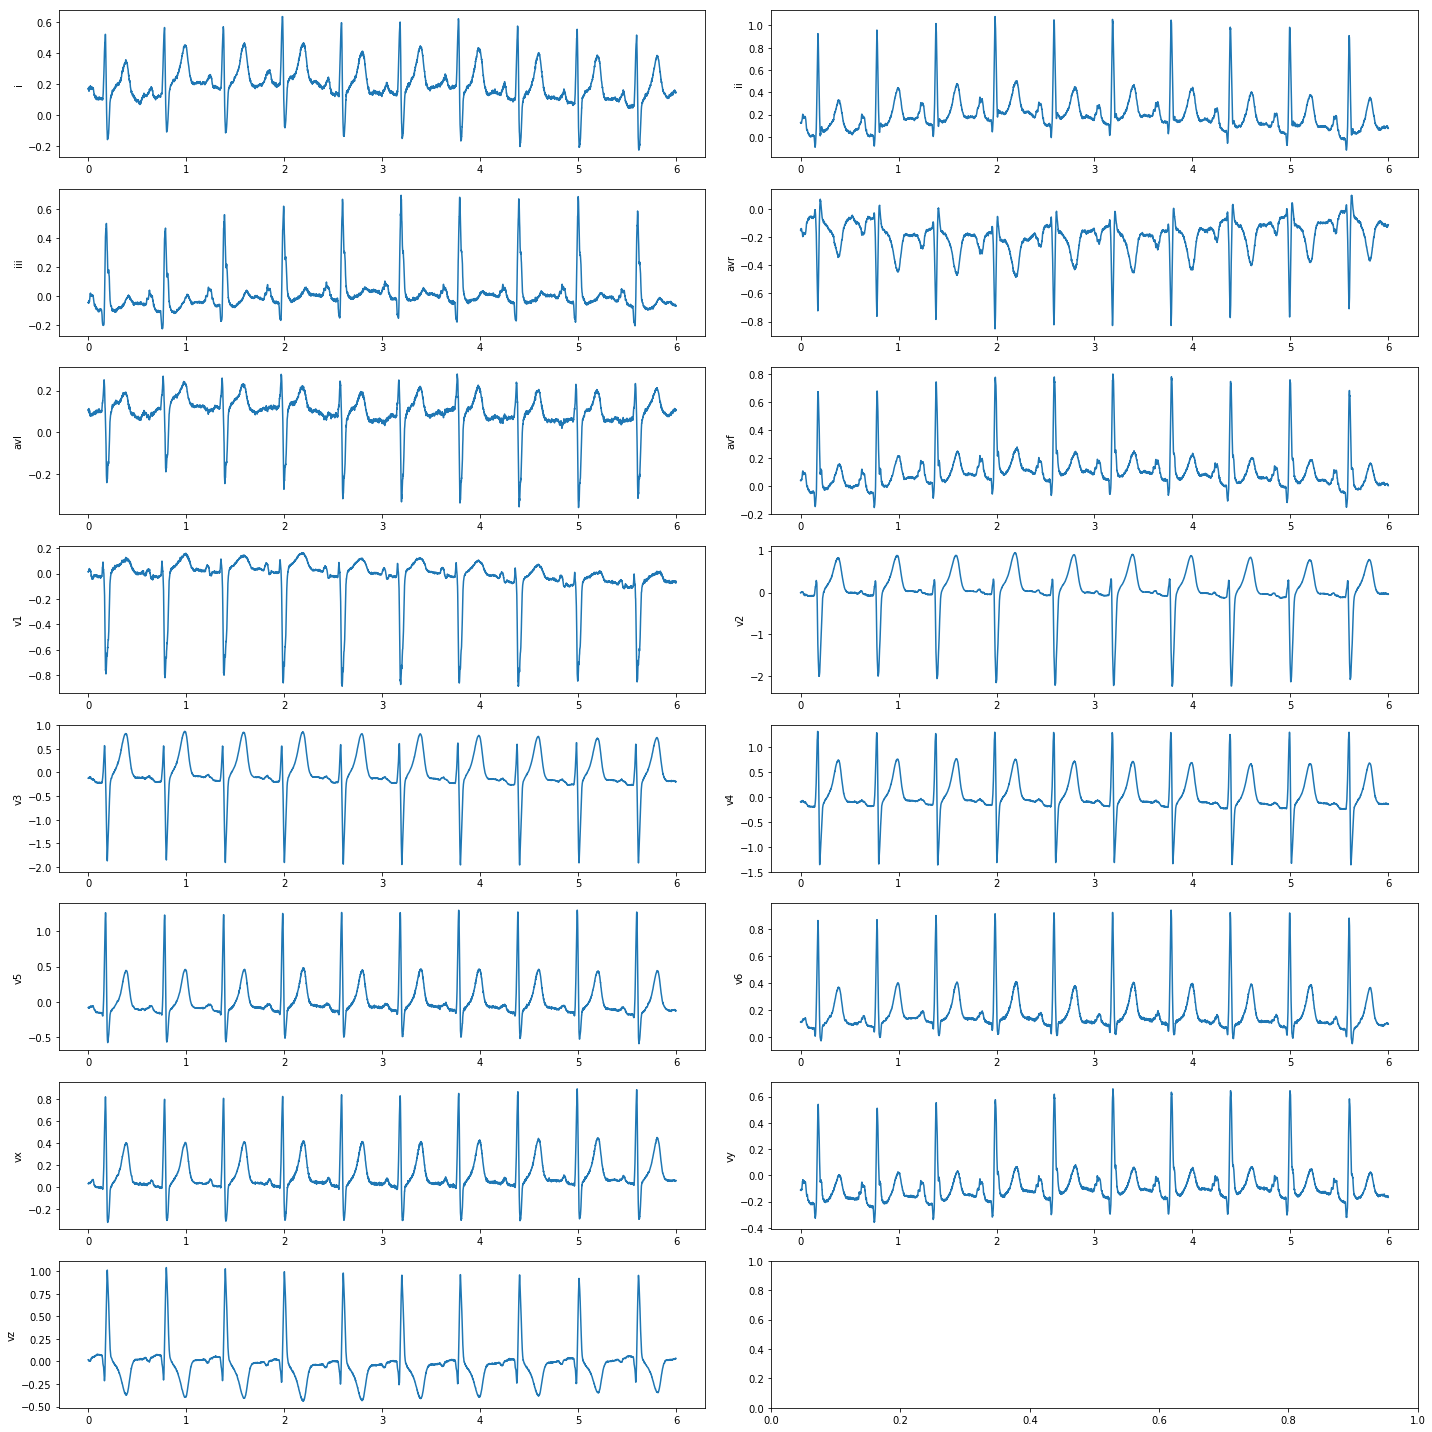

In [223]:
plot_record(healthy_data[0])

### Sick Plot

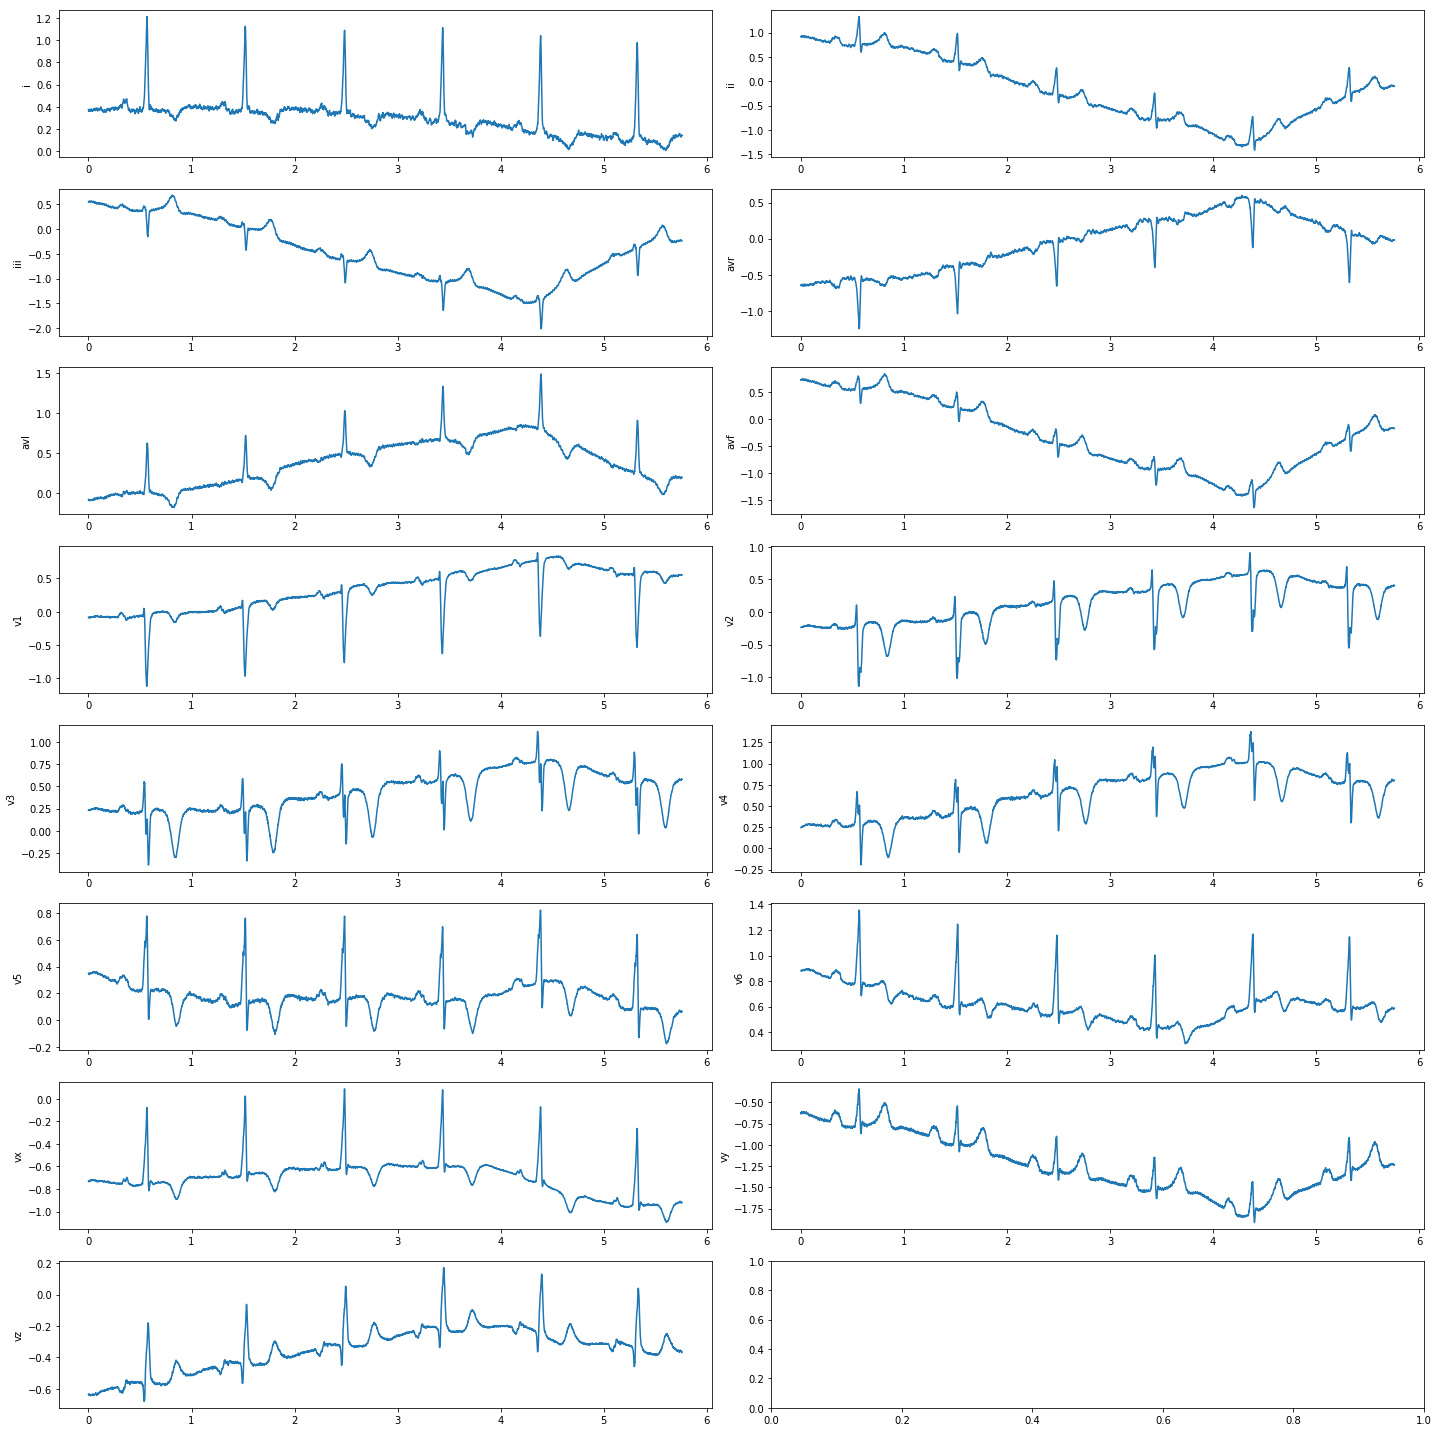

In [225]:
plot_record(unhealthy_data[0])

We want to investigate whether the models can find enough differences to distinguish between the two.

# Methods

A major source which helped me know how to do the following (or at least what tools to use) is Pandit's (see Resources section). 

## Adjusting for skews in time

Looking at the entire time series, there is a deviation over time. We need to flatten this out.

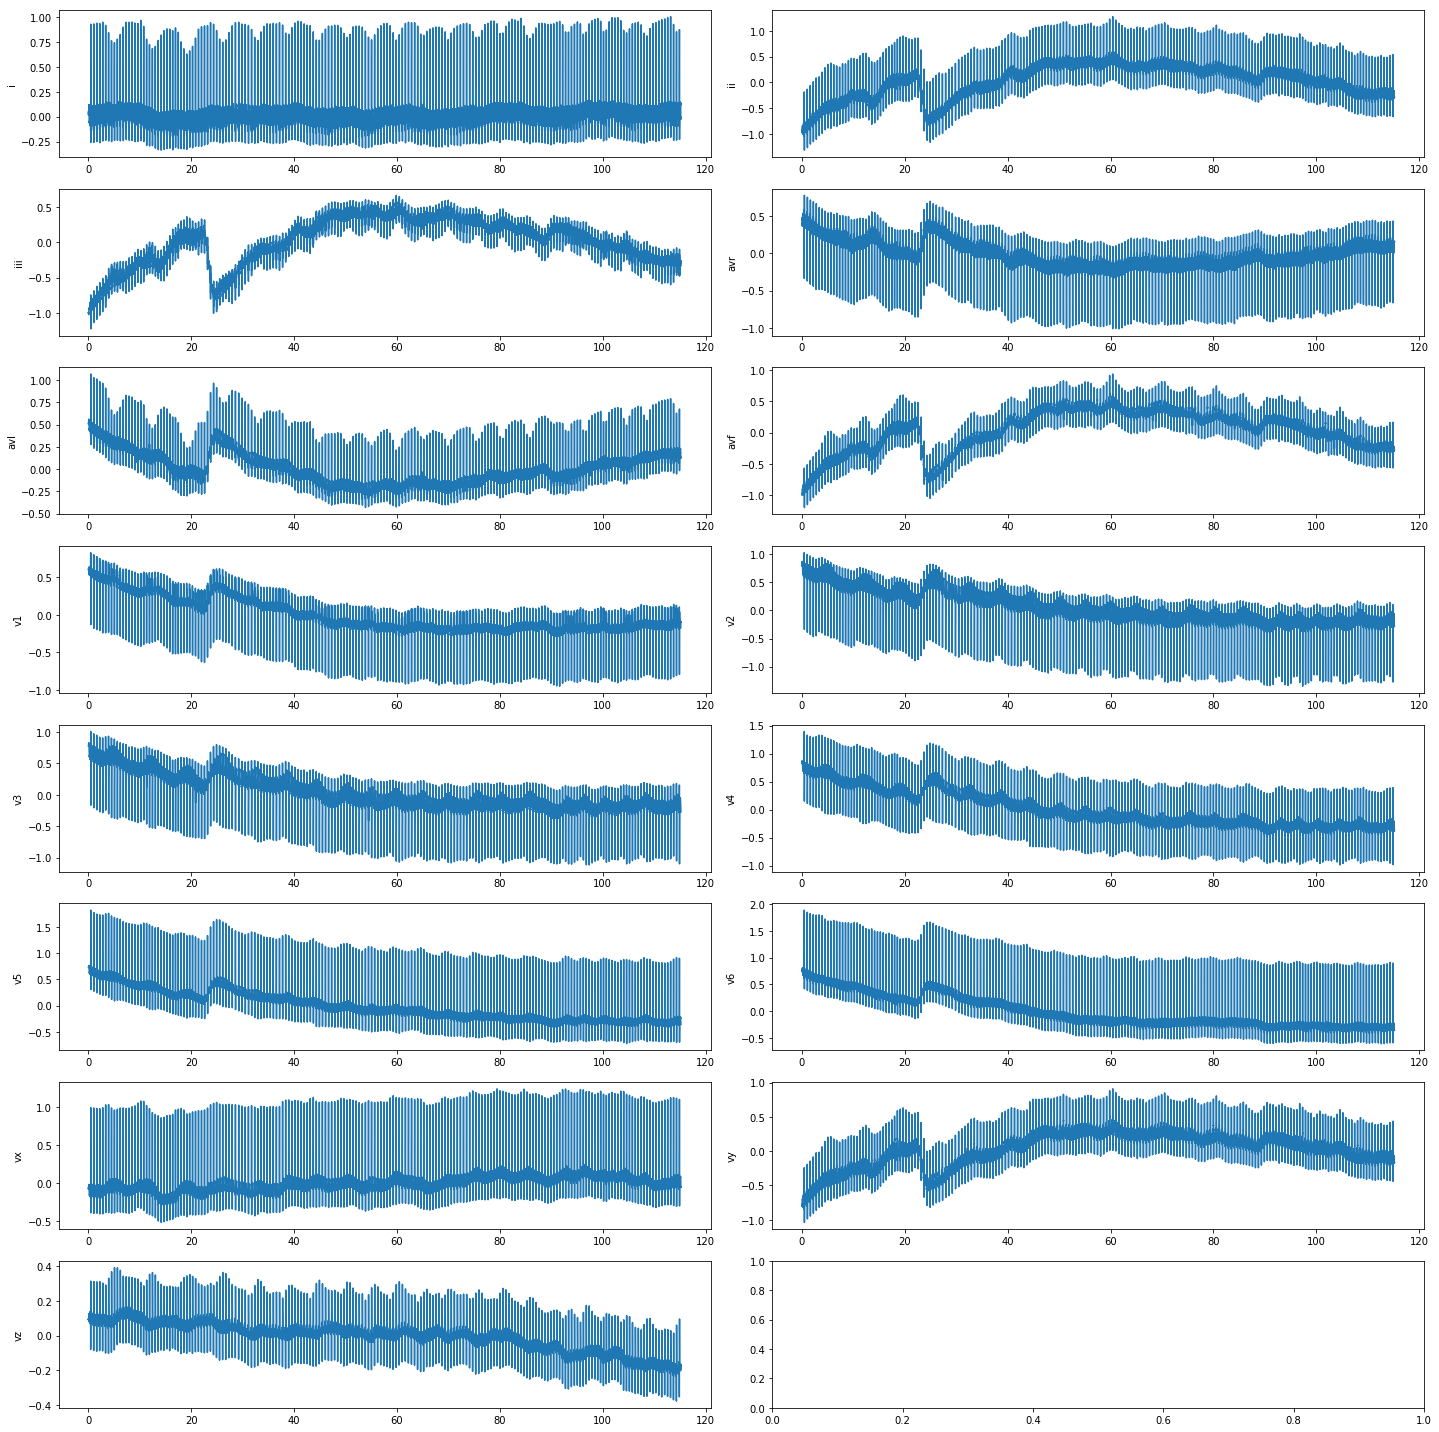

In [6]:
plot_record(healthy_data[0], split=1)

From Pandit, we subtract from every point the mean of the points surrounding it. This is imlpemented in a function `baseline`.

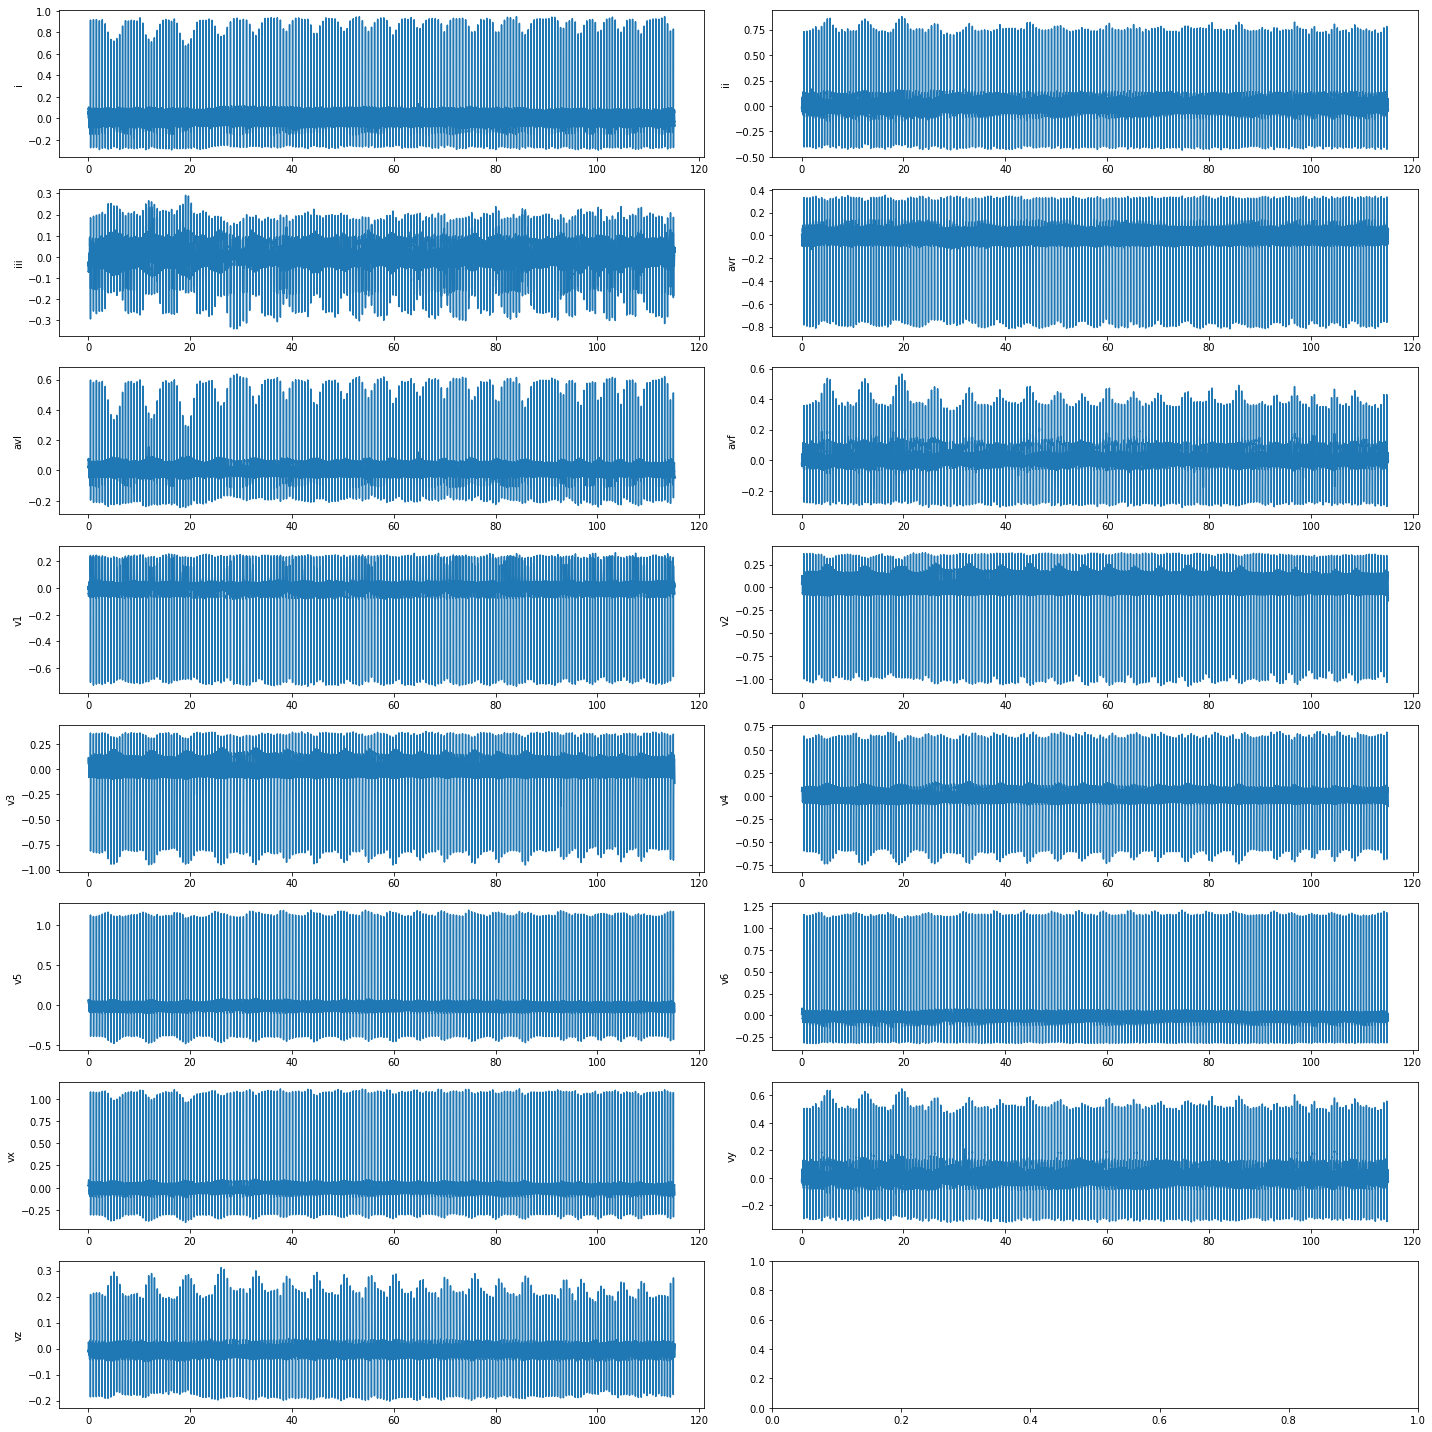

In [7]:
plot_record(healthy_data[0], split=1, raw=baseline(healthy_data[0]['data']))

## Noise Reduction

Next, we need to eliminate noise. In the graph below, the noise issue can be seen.

With Pandit's process, this can be done with wavelet decomposition. 
I use a package called `PyWavelets`, aka `pywt`, to do the decomp.
We set small values in the detail vector of the signal to zero. When
reconstructing the signal, the high frequency noise is gone. This has
an added benefit of preserving the original signal, which may contain 
a descriminator for sick vs healthy.

First, we calculate some base threshold. This is the average between the mean 
of the absolute signal and the signal's maximum value.
To calculate the threshold used in noise reduction, we take
some percentage of the base threshold. This is implemented in my function called
`reduce_noise`.

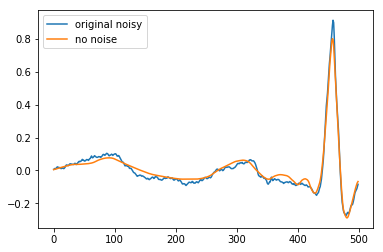

In [8]:
segment = baseline(healthy_data[0]['data'][:, 0])
plt.plot(segment[0:500], label='original noisy')
segment = reduce_noise(segment, level=None, threshold=.2)
plt.plot(segment[0:500], label='no noise')
plt.legend()

Below, we can see the overal shape is still good.

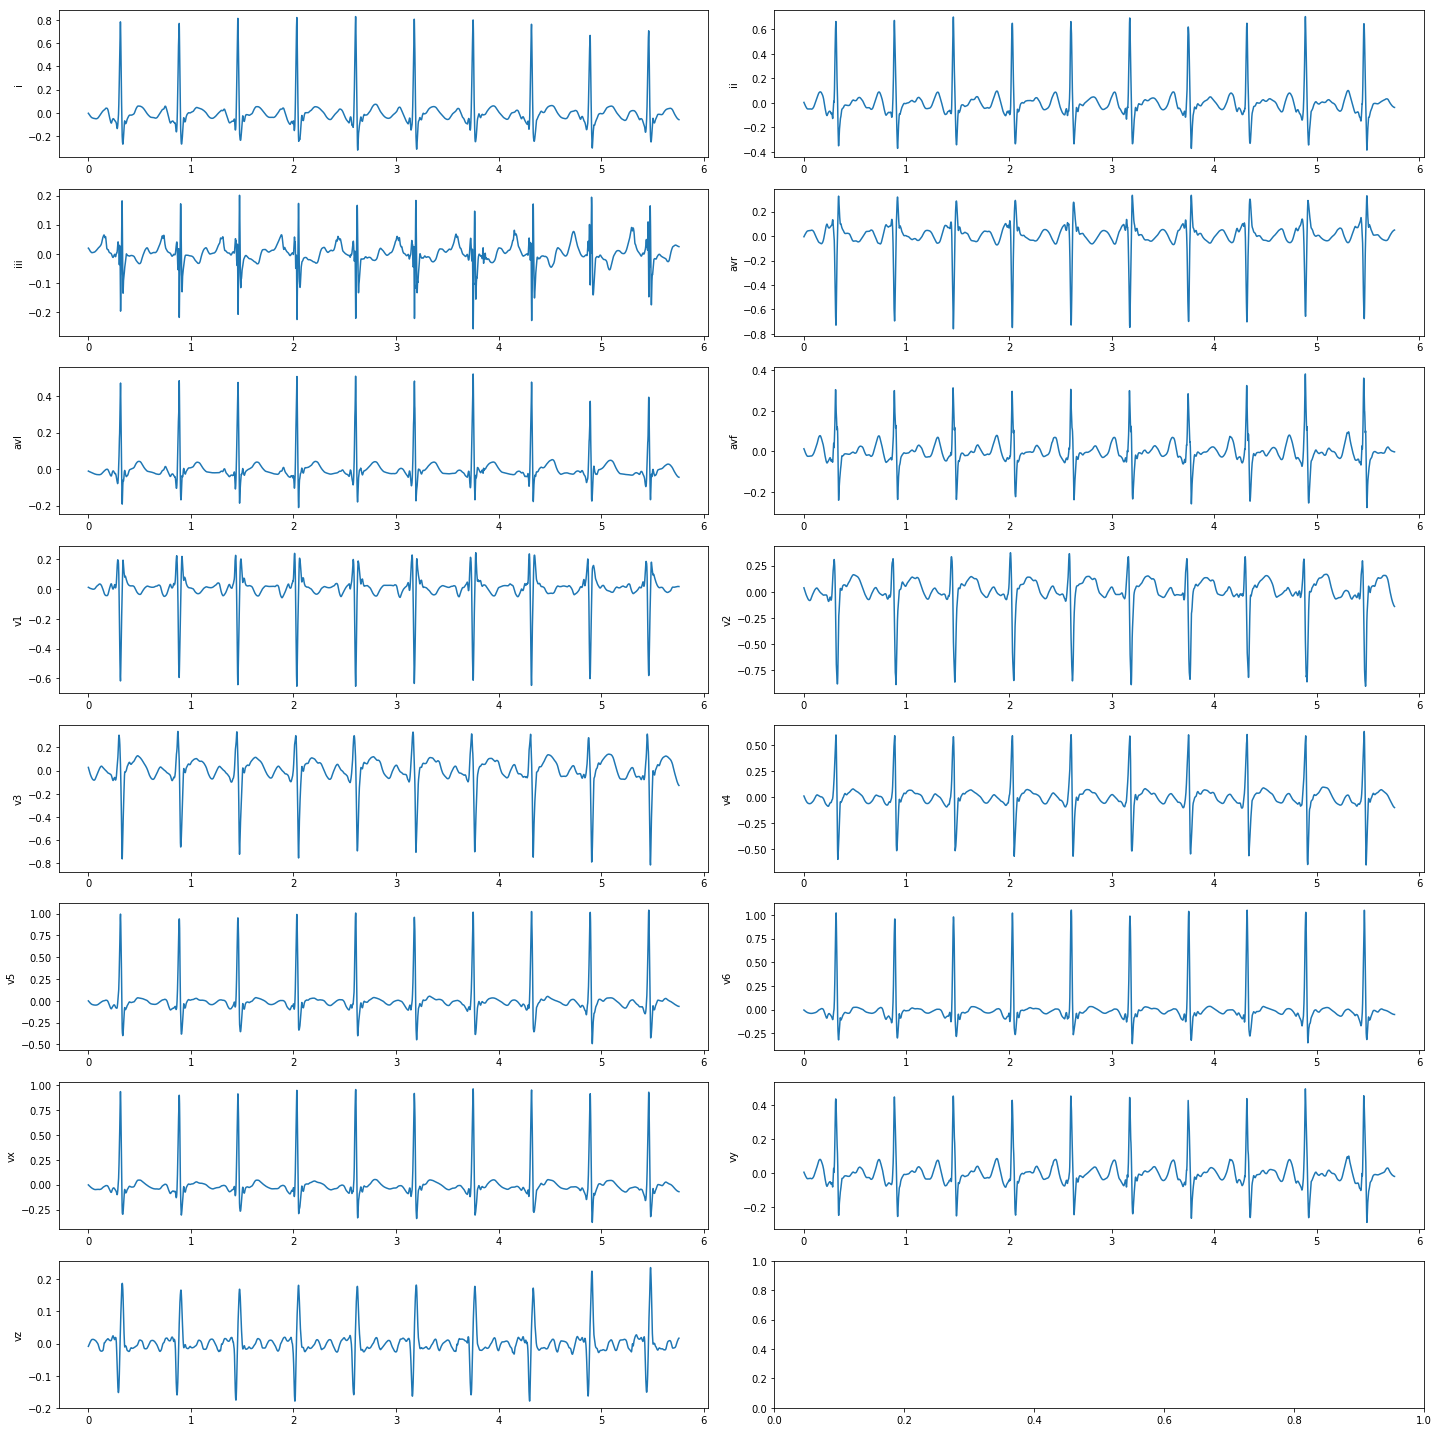

In [9]:
record = healthy_data[0]
base = baseline(record['data'])
nonoise = reduce_noise(base, threshold=.2)
plot_record(record, raw=nonoise)

## Feature Extraction

Now, that we have a clean signal, we can extract features from it. These features will then server as the 
input values to a classifier. Since the data is very periodic, FFTs will perform very well.

This creates a decomposition of coefficients to the standard Forrier series (with `sin` and `cos` as the linearly independent basis functions). Each basis function has a core frequency and the amplitude associated with this frequency tells how strongly that frequency appears in the signal. Over time, the frequencies might change, but with baseline and noise reduction, this isn't a large issue (as it would be for EKG or less periodic signals). In those cases, a concept, which I didn't get to, is used called windowing.

The actual basis function is Euler's formula, so some of the coefficients have complex values despite being a real valued signal. A common practice is to use the log power spectrum and only positive frequencies. I also drop the center coefficient since it's a vertical shift, and that doesn't affect the heartbeat. The log power spectrum is the $log_{10}(|a_i|^2)$ for every coefficient $a_i$. This maps complex values to the real domain. Only the absolute value is necessary, but the log component makes the noise easier to see. Strong frequencies will have sharp spikes, but 
weak frequencies that change a lot over the course of the signal will be "fat".

I wrote `get_signal` and `fft_exp` to extract the decomposition from a record. The fft process also extracts peaks from the graph which represent the major frequencies.

In [278]:
record = healthy_data[0]
dim=0
signal, T = get_signal(record, dim=dim)
print('ts signal shape:', signal.shape)
t = np.arange(0, signal.shape[0])/T
xf, sf, peaks = fft_exp(signal, T)
print('dominant frequency:', xf[peaks[0]], 'beat per sec')

ts signal shape: (120012,)
dominant frequency: 1.6498350164983502 beat per sec


`xf` stores the frequencies, `sf` stores the amplitudes of those frequencies. `peaks` is an indexing variable which 
has the location of peaks in order of amplitude (`peaks[0]` has the dominant frequency).

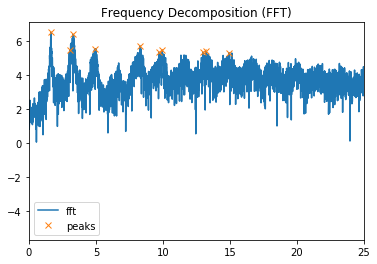

In [282]:
plot_peaks(xf, sf, peaks[:10], xlim=(0, 25))
plt.ylabel('log scale amplitude')
plt.xlabel('frequency (per second)')
plt.legend(['fft', 'peaks'])
plt.title('Frequency Decomposition (FFT)');

The x's show where the peaks are. There are a few things to note. The peaks are not spikes, and they are kind of fatter. This means that the frequencies are not completely dominating and there is noise horizontally accross the signal. This will make the features a little more difficult to extract automatically.

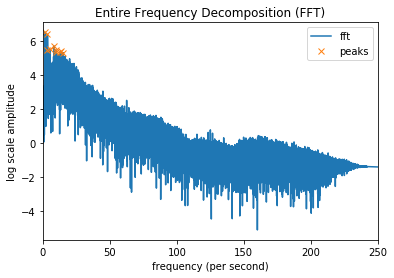

In [284]:
plot_peaks(xf, sf, peaks[:10], xlim=(0, 250))
plt.ylabel('log scale amplitude')
plt.xlabel('frequency (per second)')
plt.legend(['fft', 'peaks'])
plt.title('Entire Frequency Decomposition (FFT)');

Looking at the entire FFT, we can see the high frequencies drop to very low values. This means that we can ignore a large majority of these values.

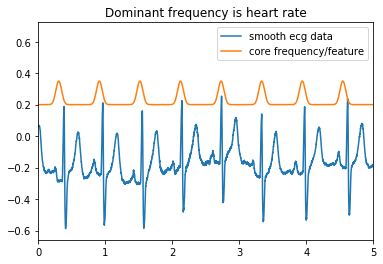

In [285]:
plt.figure()
plt.plot(t, record['data'][:, dim], label='smooth ecg data')
plt.plot(t, .2+.15*np.sin(xf[peaks[0]]/2 * 2*np.pi*t)**20, label='core frequency/feature')
plt.xlim((0, 5))
plt.title("Dominant frequency is heart rate")
plt.legend();

In this graph, we can see that the dominant frequency (`xf[beats[0]]`) correlates with the heart beat. This doesn't work with every record, usually because heartbeat varies too much over the sample (of roughly 2 minutes) of some.

The featuers which are used to train the model are going to be a portion of these low frequency peaks. In the cell below, you can see there are a lot of samples for frequencies less than 25: 3001.

In [298]:
xf[xf<25].shape

(3001,)

Of these samples, there are 90 peaks.

In [299]:
xf[peaks[xf[peaks] < 25]].shape

(90,)

The input vector needs to be constant and the number of peaks varies slightly, so we will use the top 75 frequencies and their amplitudes as the input vectors. Also, it's worth pointing out that 14 of the dimensions of the signal are ignored. Only the 1st dimension is used. Performance would increase if all are used, but I chose to take a simple route since analyzing all 15 would require a more complex FFT, but I want to explore a single signal decomposition.

# Results

Now, we split the entire dataset into training and testing. The wrapper function for this is `get_xt`. 

In [122]:
data_matrix = get_xt()
train_x, train_t, test_x, test_t = data_matrix
[d.shape for d in data_matrix]

Getting healthy features
Getting sick features


[(339, 150), (339, 1), (86, 150), (86, 1)]

Then, we train a classifier (`NeuralNetworkClassifier`) to classify sick vs control.

In [303]:
count = (np.sum(np.vstack((test_t, train_t))).astype(int), np.sum(1-np.vstack((test_t, train_t))).astype(int))
print("Number of sick: {}\nNumber of control: {}".format(*count))

Number of sick: 346
Number of control: 79


From above, you can see there are much more sick than control. This might become an issue if our model decides the best predictor is to just guess that everyone is sick. So the measurement we will use for performance is an average of the performances for each class (sick vs control). This is implemented in a method called `bsr` (for ballanced success rate), and it takes
the confusion matrix as the parameter. It has the property of returning .5 if the model guesses only one class for every sample. I also calculate the accuracy (num incorrect divided by total).

In [318]:
cm = np.array([[1000, 0], [1, 0]]) 
print("Bad BSR: {} \nvs\nGood Accuracy: {}\nConf mat:".format(bsr(cm), acc(cm)))
print(cm)

Bad BSR: 0.5 
vs
Good Accuracy: 0.999000999000999
Conf mat:
[[1000    0]
 [   1    0]]


training data shape: (339, 150)
confusion matrix:
 [[ 9  7]
 [10 60]]
bsr: 0.7098214285714286
acc: 0.8023255813953488


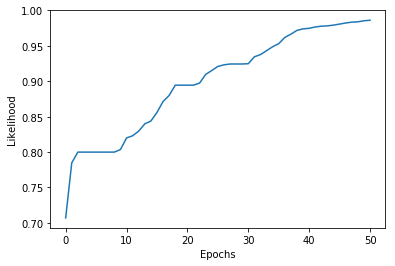

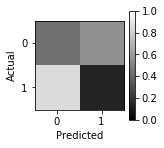

In [310]:
nHidden = [5, 5]

nnet = NeuralNetworkClassifier(train_x.shape[1], nHidden, 2)
nnet.train(train_x, train_t, nIterations=50)
test_y = nnet.use(test_x)

plt.figure()
plt.plot(np.exp(-nnet.getErrorTrace()))
plt.xlabel("Epochs")
plt.ylabel("Likelihood")

cm = sklearn.metrics.confusion_matrix(test_t, test_y)
plot_cm(cm)
print('training data shape:', train_x.shape)
print('confusion matrix:\n', cm)
print('bsr:', bsr(cm))
print('acc:', acc(cm))

# Conclusion

This code block can be run multiple times. The accuracy is always higher than the bsr, so it's very likely the model overtrains and leans towards guessing sick. However, my results found that allowing it to train on more sick points increased performance. 

The performance also varied a lot with each run. Different network sizes didn't improve or degrade performance significantly. Typical BSR values were in the range of .7 to .75. When accuracy was highest, BSR was low. Overall, these results aren't strong, but my understanding of Wavelets and Fourier Transforms has increased a lot, and with
more data and more careful preprocessing, these results could prove very effective.

# References

### ECG Preprocessing (Journal)
Pandit, Diptangshu, et al. "Noise reduction in ECG signals using wavelet transform and dynamic thresholding." Emerging Trends in Neuro Engineering and Neural Computation. Springer, Singapore, 2017. 193-206.

### Wavelets Guide (Blog)
http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

### Data
https://physionet.org/physiobank/database/ptbdb/

Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23):e215-e220 [Circulation Electronic Pages](http://circ.ahajournals.org/content/101/23/e215.full); 2000 (June 13).

### Fourier Background
http://archive.schools.cimpa.info/archivesecoles/20110804111512/aline_slides.pdf

### Fourier = PCA
https://www.quora.com/Is-there-something-like-principal-component-analysis-for-time-series

# Word Count

In [20]:
import io
from IPython.nbformat import current
import glob
nbfile = glob.glob('FinalReport.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file FinalReport.ipynb is 1391
